In [ ]:
pip install --upgrade tensorflow==2.9.1

In [1]:
import matplotlib.pyplot as plt 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns

In [4]:
import cv2

In [10]:
import tensorflow as tf
tf.__version__
#the output of this should be 2.9.x as tensorflow 2.10 has a nasty bug that makes it impossible to save ur model after training

'2.9.1'

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
from tqdm import tqdm
import os
from sklearn.utils import shuffle


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
from tensorflow.keras.applications import EfficientNetB0

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
import io

In [18]:
from PIL import Image

In [19]:
from IPython.display import display, clear_output

## Basic set up

In [20]:
labels = ['glioma', 'no_tumor','meningioma','pituitary_tumor','neurocytoma','schwannoma','other_abcess_cyst_encephalopathy']

In [21]:


X_train = []
y_train = []
os.getcwd()
os.chdir('/content/drive/MyDrive')


In [22]:
#scaling our images to 150px by 150px to make training easier/convenient
scaleDown = 150
#these 2 for loops are horrendous i know, i can't be bothered to make them more elegant, sorry
for i in labels: 
    folderPath = os.path.join('Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (scaleDown, scaleDown))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (scaleDown, scaleDown))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 37/37 [00:00<00:00, 124.22it/s]


In [23]:
X_train, y_train = shuffle(X_train, y_train, random_state=101)

In [24]:
X_train.shape

(7712, 150, 150, 3)

In [25]:
#The (3002, 150, 150, 3) is the final shape of our training data (the 3002 images that have been scaled to
# 150x150px with 3 channels and converted to an np array)

### Splitting the Data into Training and Testing

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.08, random_state=101)

### Converting the text based values of the y_train array into numerical values

In [27]:
y_train_final = []
for i in y_train:
    y_train_final.append(labels.index(i))
y_train = y_train_final
y_train = tf.keras.utils.to_categorical(y_train)


y_test_final = []
for i in y_test:
    y_test_final.append(labels.index(i))
y_test = y_test_final
y_test = tf.keras.utils.to_categorical(y_test)


In [28]:
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(scaleDown, scaleDown,3))

In [29]:
model = effnet.output

In [30]:
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(7, activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [31]:
# model.summary() to get a useful summary about our model

In [32]:
model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

In [41]:
#callbacks
tensorboard = TensorBoard(log_dir = 'logs')
#cp_callback is for saving the model as we train
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='final.chkpt',save_weights_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor=0.3, patience=2, min_delta=0.002, mode='auto', verbose=1)

In [ ]:
## Loading the saved weights from out trained model to avoid re-training
checkpoint_path = "checkpoint/training1.chkpt"
model.load_weights(checkpoint_path)



In [ ]:
##Evaluate the model after loading the weights
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [42]:
##Training the model (Leaning Step)
history = model.fit(X_train,y_train,validation_split=0.1, epochs=10, verbose=1, batch_size=30, callbacks=[tensorboard,reduce_lr])

Epoch 1/10
213/213 [==============================] - 38s 169ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.0909 - val_accuracy: 0.9803 - lr: 9.0000e-05
Epoch 2/10
213/213 [==============================] - 33s 153ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.0752 - val_accuracy: 0.9831 - lr: 9.0000e-05
Epoch 3/10
213/213 [==============================] - 32s 150ms/step - loss: 0.0038 - accuracy: 0.9994 - val_loss: 0.0833 - val_accuracy: 0.9817 - lr: 9.0000e-05
Epoch 4/10
213/213 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
213/213 [==============================] - 32s 151ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0755 - val_accuracy: 0.9831 - lr: 9.0000e-05
Epoch 5/10
213/213 [==============================] - 33s 153ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0796 - val_accuracy: 0.9831 - lr: 2.7000e-05
Epoch 6/10
213/213 [=========

# **Saving our model**

In [43]:
model.save('saved_model/my_model')

In [44]:
pred = model.predict(X_test)

20/20 [==============================] - 1s 32ms/step


In [45]:
pred = np.argmax(pred,axis=1)

In [46]:
y_test_final = np.argmax(y_test, axis=1)

In [47]:
print(classification_report(y_test_final,pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       178
           1       1.00      0.97      0.99        76
           2       0.96      0.98      0.97       189
           3       0.98      1.00      0.99        60
           4       0.98      0.98      0.98        46
           5       0.96      1.00      0.98        45
           6       1.00      0.96      0.98        23

    accuracy                           0.98       617
   macro avg       0.98      0.98      0.98       617
weighted avg       0.98      0.98      0.98       617



## Loading a new image and making a prediction using our model

1/1 [==============================] - 0s 135ms/step
The model predicts : neurocytoma


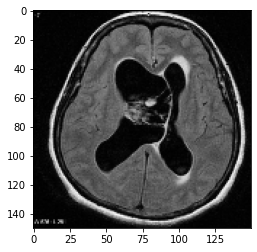

In [50]:
img = Image.open(r"ImagesForPrediction/b193be03b32013b8661ec3da8e6c2a_gallery.jpeg")
opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
img = cv2.resize(opencvImage, (150,150))
plt.imshow(img)
img = img.reshape(1,150,150,3)
prediction = model.predict(img)
prediction = np.argmax(prediction,axis=1)[0]
    
    
if prediction==0:
  prediction='Glioma'
elif prediction==1:
  prediction='No Tumor'
elif prediction==2:
  prediction='Meningioma'
elif prediction==3:
  prediction='Pituitary Tumor'
elif prediction==4:
  prediction="neurocytoma"  
elif prediction==5:
  prediction='schwannoma'
elif prediction==6:
  prediction="other lesions(abcess,cyst,encephalopathy)"     
 
    
print(f'The model predicts : {prediction}')    

In [ ]:
#@title Loading saved modules 

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

# Check its accuracy
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
